### ⚙️ Libs/Configs

Instalação de dependências

In [ ]:
!pip install pandas beautifulsoup4 openpyxl langchain langchain_core langchain-anthropic langchain-openai langchain_google_genai langgraph

Importação de dependências

In [ ]:
import os, requests, re
import getpass

from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

from langchain.schema.runnable import RunnableLambda, RunnableParallel
from langchain_anthropic import ChatAnthropic
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI

from bs4 import BeautifulSoup
from time import sleep
from random import randint
from openpyxl import Workbook
from openpyxl.cell.cell import ILLEGAL_CHARACTERS_RE
from typing import List, Dict, Optional
from typing_extensions import TypedDict


Definição de LLM

In [ ]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

#_set_env("ANTHROPIC_API_KEY")
# llm = ChatAnthropic(model="claude-3-5-sonnet-latest")

#_set_env("OPENAI_API_KEY")
#llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

#_set_env("GOOGLE_API_KEY")
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0)

Testando conexão com LLM

In [16]:
llm.invoke("Write me a short ballad about LangChain")

AIMessage(content='The Bard of Code, with fingers swift,\nDid weave a tale of modern gift,\nA chain of language, strong and bright,\nTo bring forth knowledge, day and night.\n\nFrom distant models, vast and deep,\nWhere secrets of the language sleep,\nHe drew the threads, a silken line,\nAnd bound them with a clever design.\n\nLangChain he named this wondrous thing,\nTo answer questions, make bells ring,\nTo summarize and to create,\nAnd automate with skillful gait.\n\nHe fed it data, rich and wide,\nFrom documents where truths reside,\nAnd watched it learn, with eager grace,\nTo find the answers in their place.\n\nThrough agents bold, it did explore,\nThe internet, from shore to shore,\nAnd tools it wielded, sharp and keen,\nTo gather facts, unseen, between.\n\nBut still, the Bard did caution all,\n"With great power, comes a fall!\nLangChain\'s wisdom, though profound,\nMust be with human judgment crowned."\n\nSo use it wisely, learn its ways,\nAnd guide its steps through future days,

# 🚦 WorkFlows

Os "Workflows" são fluxos de trabalho que têm caminhos de código predeterminados e são projetados para operar em uma determinada ordem.


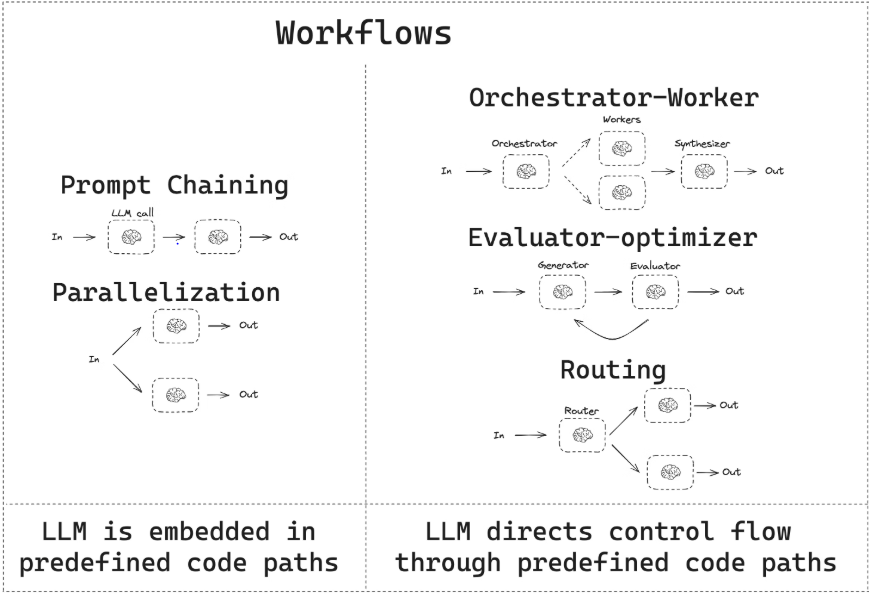

### 🔗 Prompt Chaining

#### 📚 Conceito

O encadeamento de prompts é uma técnica essencial para o uso eficaz de LLMs em tarefas complexas, essa metodoligia também chamada de pipeline foca em dividir para conquistar, dividindo um problema em sequências de subproblemas, onde o ouput de um prompt alimenta estrategicamente o próximo, elevando a confiabilidade e o controle do processo.

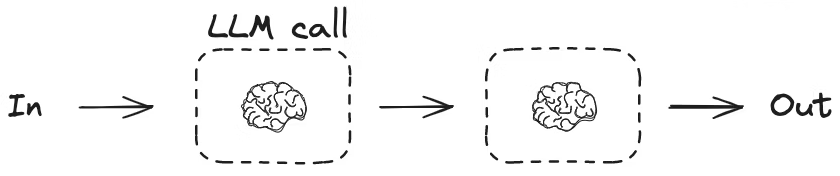

Alguns exemplos de caso de uso:

1 - Criar pipeline de dados para geração de relatórios estratégicos

2 - Gerar textos de marketing e depois traduzi-los para idiomas diferentes

3 - Escrever um esboço de um documento, verificar se o esboço atende a determinados critérios e, em seguida, escrever o documento com base no esboço.

#### 📝 Exemplos

##### 📌 Exemplo 1 (Worflow para geração de Piadas)

Criação de dicionário representando o estado que pode ser alterando durante execução do grafo.

In [24]:
# Graph state
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str

Criação de nós que serão compilados no grafo.

In [25]:
# Nodes
def generate_joke(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}


def check_punchline(state: State):
    """Gate function to check if the joke has a punchline"""

    # Simple check - does the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Pass"
    return "Fail"


def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}


def polish_joke(state: State):
    """Third LLM call for final polish"""
    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}

Criação do WorkFlow

In [26]:
# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke", check_punchline, {"Pass": "improve_joke", "Fail": END}
)
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile
chain = workflow.compile()

Visualização do Grafo

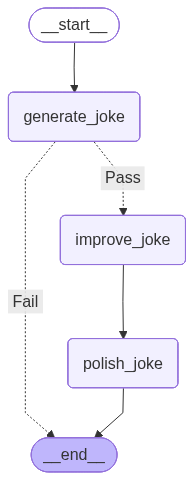

In [27]:
# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))

In [31]:
# Invoke
state = chain.invoke({"topic": "cats"})
print("✅ Initial joke:")
print(state["joke"])
print("\n--- --- ---\n")
if "improved_joke" in state:
    print("✅ Improved joke:")
    # print(state["improved_joke"])
    print("\n--- --- ---\n")

    print("✅ Final joke:")
    print(state["final_joke"])
else:
    print("❌ Joke failed quality gate - no punchline detected!")

✅ Initial joke:
Why did the cat join the Red Cross?

Because he wanted to be a first-aid kit!

--- --- ---

✅ Improved joke:

--- --- ---

✅ Final joke:
Okay, I agree that Option 2 ("Purr-amedic") is the strongest starting point. Here's the joke with a surprising twist added:

> Why did the cat join the Red Cross?
>
> He wanted to become a **purr-amedic** and give everyone a helping paw! ...But mostly he just wanted to nap in the first aid kits.


##### 📌 Exemplo 2

### ⛓️ Paralelization

#### 📚 Conceito

Com a paralelização, os WorkFlows podem ter tarefas que sõ executadas de forma simultanea.
Às vezes, os LLMs podem trabalhar simultaneamente em uma tarefa e ter seus resultados agregados programaticamente. 
A paralelização, se manifesta em duas variações principais: 

**Seccionamento**: Dividir uma tarefa em subtarefas independentes executadas em paralelo. 

**Votação**: Executar a mesma tarefa várias vezes para obter resultados diversos.

**Quando usar no fluxo de trabalho**: A paralelização é eficaz quando as subtarefas divididas podem ser paralelizadas para maior velocidade ou quando múltiplas perspectivas ou tentativas são necessárias para resultados mais confiáveis. 
Para tarefas complexas com múltiplas considerações, os LLMs geralmente têm melhor desempenho quando cada consideração é tratada por uma chamada de LLM separada, permitindo atenção focada em cada aspecto específico.

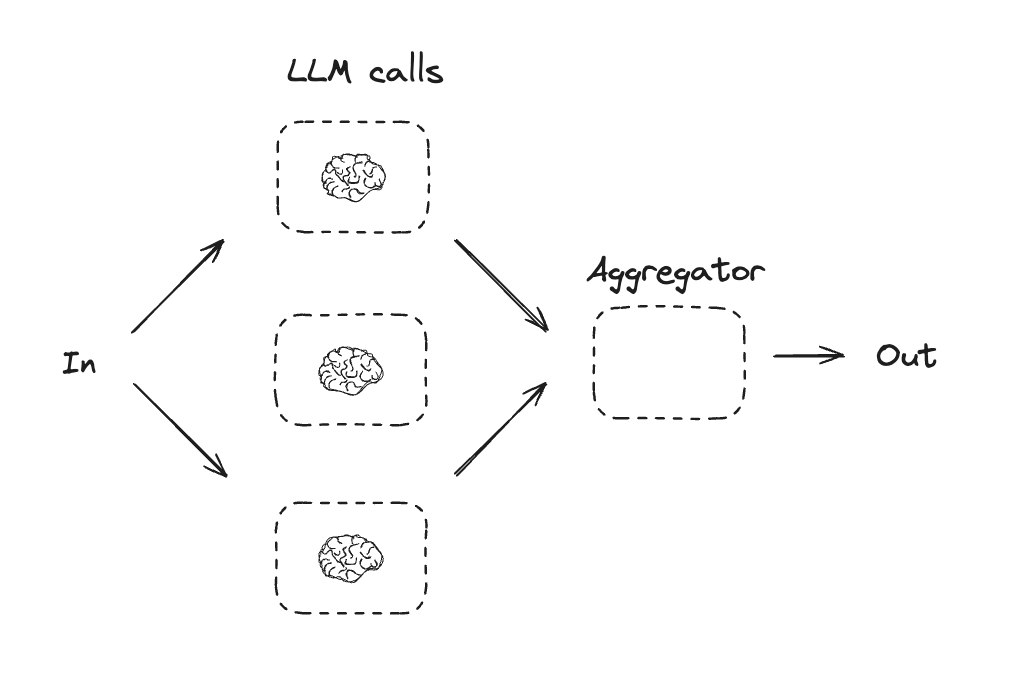

#### 📝 Exemplos

##### 📌 Exemplo 1

In [50]:
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str

Criação de nós

In [81]:
# Nodes
def call_llm_1(state: State):
    """First LLM call to generate initial joke"""
    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    state["joke"] = msg.content
    return state


def call_llm_2(state: State):
    """Second LLM call to generate story"""
    msg = llm.invoke(f"Write a short story with one line about {state['topic']}")
    state["story"] = msg.content
    return state

def call_llm_3(state: State):
    """Third LLM call to generate poem"""
    msg = llm.invoke(f"Write a short poem about {state['topic']}")
    state['poem'] = msg.content
    return state

def aggregator(state: State):
    """Combine the joke and story into a single output"""
    print(state)

    combined = f"Here's a story, joke, and poem about {state['topic']}!\n\n"
    combined += f"STORY:\n{state.get('story', '')}\n\n"
    combined += f"JOKE:\n{state.get('joke', '')}\n\n"
    combined += f"POEM:\n{state.get('poem', '')}"

    print(combined)
    return {"combined_output": combined}

Craindo grafo

In [82]:
# Build workflow
parallel_workflow = StateGraph(State)

# Add nodes
parallel_workflow.add_node("call_llm_1", call_llm_1)
parallel_workflow.add_node("call_llm_2", call_llm_2)
parallel_workflow.add_node("call_llm_3", call_llm_3)
parallel_workflow.add_node("aggregator", aggregator)

# Add edges to connect nodes
parallel_workflow.add_edge(START, "call_llm_1")
parallel_workflow.add_edge(START, "call_llm_2")
parallel_workflow.add_edge(START, "call_llm_3")
parallel_workflow.add_edge("call_llm_1", "aggregator")
parallel_workflow.add_edge("call_llm_2", "aggregator")
parallel_workflow.add_edge("call_llm_3", "aggregator")
parallel_workflow.add_edge("aggregator", END)
parallel_workflow = parallel_workflow.compile()

Exibição do grafo

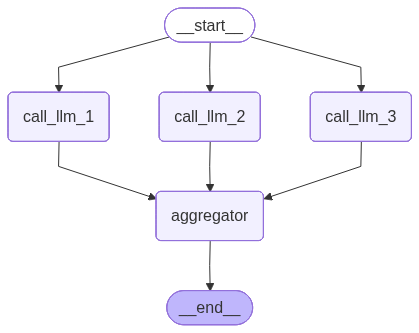

In [83]:
# Show workflow
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

Invocação de grafo

In [84]:
# Invoke
state = parallel_workflow.invoke({"topic": "cats"})
print(state)

InvalidUpdateError: At key 'topic': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE

##### 📌 Exemplo 2 (Seccionamento)

In [ ]:
SYMPLA_EVENTS_URL: str = 'https://www.sympla.com.br/eventos'
ESCOLA_VIRTUAL_GOV_URL: str = 'https://www.escolavirtual.gov.br'
USP_APOLO_URL: str = 'https://uspdigital.usp.br/apolo'
CURSOS_USP_URL: str = f'{USP_APOLO_URL}/apoListarUltimosCursosOferecidos'


class EventsCrawler:
    """
    Classe para realizar a raspagem de eventos de diferentes plataformas online.
    """

    def sympla_crawler(self, category: str) -> List[List[str]]:
        """
        Raspagem de eventos da plataforma Sympla.
        
        :param category: Categoria do evento a ser buscada.
        :return: Lista contendo eventos com título, local, período e URL.
        """
        results: List[List[str]] = []
        page: int = 1
        
        while True:
            try:
                response = requests.get(f"{SYMPLA_EVENTS_URL}/{category}/todos-eventos?page={page}")
                response.raise_for_status()
                soup = BeautifulSoup(response.text, "html.parser")
                cards = soup.find_all("a", class_="sympla-card")
                
                if not cards:
                    break
                
                for card in cards:
                    event_url: str = card["href"]
                    if "play" in event_url:
                        continue
                    
                    event_title: str = ILLEGAL_CHARACTERS_RE.sub("", card.find("h3").text)
                    event_local: str = card.find("p", class_="pn67h1c").text
                    event_period_elements = card.find_all("div", class_="pn67h1b", limit=2)
                    event_period: str = (
                        f"{event_period_elements[0].text} > {event_period_elements[-1].text}"
                        if event_period_elements else ""
                    )
                    
                    results.append([event_title, event_local, event_period, event_url])
                
                sleep(randint(1, 2))
                page += 1
            except requests.RequestException as e:
                print(f"Erro ao acessar Sympla: {e}")
                break
            except Exception as e:
                print(f"Erro inesperado: {e}")
                break
        
        return results

    def evg_crawler(self) -> List[List[str]]:
        """
        Raspagem de cursos da Escola Virtual do Governo.
        
        :return: Lista contendo cursos com título, local, período e URL.
        """
        results: List[List[str]] = []
        page: int = 1
        
        while True:
            try:
                response = requests.get(f"{ESCOLA_VIRTUAL_GOV_URL}/catalogo?page={page}")
                response.raise_for_status()
                soup = BeautifulSoup(response.text, "html.parser")
                
                if "Lamentamos, não encontramos nenhum curso disponível." in soup.get_text():
                    break
                
                grid = soup.find("div", class_="courseboxes flex-container")
                if not grid:
                    break
                
                courses = grid.find_all("div")
                for course in courses:
                    course_title: Optional[str] = course.find("h3").get_text() if course.find("h3") else ""
                    course_url_match = re.findall(r'href="([^"]+)"', str(course.find("h3")))
                    course_url: str = course_url_match[-1] if course_url_match else ""
                    course_period: str = course.find_all("dd")[-1].get_text() if course.find_all("dd") else ""
                    
                    if all([course_title, course_url, course_period]):
                        results.append([course_title, "Online", course_period, course_url])
                
                sleep(randint(2, 3))
                page += 1
            except requests.RequestException as e:
                print(f"Erro ao acessar EVG: {e}")
                break
            except Exception as e:
                print(f"Erro inesperado: {e}")
                break
        
        return results

    def usp_crawler(self) -> List[List[str]]:
        """
        Raspagem de cursos oferecidos pela USP.
        
        :return: Lista contendo cursos com título, local, período e URL.
        """
        results: List[List[str]] = []
        try:
            response = requests.get(f"{CURSOS_USP_URL}?id_formato=dist")
            response.raise_for_status()
            soup = BeautifulSoup(response.text, "html.parser")
            all_rows = soup.find_all("tr")
            
            for row in all_rows:
                url_element = row.find("a")
                if url_element:
                    row_data = [data.text for data in row.find_all("td")]
                    if "usp" in row_data or "USP" in row_data:
                        results.append([row_data[0], row_data[3], row_data[1], f"{USP_APOLO_URL}/{url_element['href']}"])
        except requests.RequestException as e:
            print(f"Erro ao acessar cursos da USP: {e}")
        except Exception as e:
            print(f"Erro inesperado: {e}")
        
        return results


def create_excel_file(wb_name: str, datas: Dict[str, List[List[str]]]) -> None:
    """
    Cria um arquivo Excel a partir dos dados extraídos.
    
    :param wb_name: Nome do arquivo Excel a ser criado.
    :param datas: Dicionário contendo os dados separados por categoria.
    """
    try:
        wb = Workbook()
        sheet_names = wb.sheetnames
        wb.remove(wb[sheet_names[-1]])
        
        for key, values in datas.items():
            ws = wb.create_sheet(key)
            for row in values:
                ws.append(row)
        
        wb.save(f"{wb_name}.xlsx")
    except Exception as e:
        print(f"Erro ao criar arquivo Excel: {e}")

Execução da extração de dados de forma paralela usando LangChain(🦜🔗)

In [ ]:
datas: dict = {}
event_crawler = EventsCrawler()

sympla_tecno_runnable = RunnableLambda(lambda _: event_crawler.sympla_crawler('tecnologia'))
sympla_workshop_runnable = RunnableLambda(lambda _: event_crawler.sympla_crawler('curso-workshop'))
sympla_congress_runnable = RunnableLambda(lambda _: event_crawler.sympla_crawler('congresso-palestra'))
usp_runnable = RunnableLambda(lambda _: event_crawler.usp_crawler())

parallel_runnables = RunnableParallel({
    "Sympla Tecnologia": sympla_tecno_runnable,
    "Sympla Cursos e Workshops": sympla_workshop_runnable,
    "Sympla Congressos e Palestras": sympla_congress_runnable,
    "USP": usp_runnable
})

datas: dict = parallel_runnables.invoke(None)
create_excel_file('events_info', datas)